# Download song from Youtube and get audio features

In [23]:
# Imports
from __future__ import unicode_literals
import youtube_dl
import librosa
import librosa.display
import audioread
import matplotlib.pyplot as plt
from os import path
from pydub import AudioSegment
import numpy as np
import pandas as pd
from scipy.signal import spectrogram
from pyACA.ToolComputeHann import ToolComputeHann
from pyACA.FeatureSpectralPitchChroma import FeatureSpectralPitchChroma
from pyACA.ToolPreprocAudio import ToolPreprocAudio
from pyACA.ToolReadAudio import ToolReadAudio
from spleeter.separator import Separator

## Download song from Youtube

In [2]:
yt_link = 'https://www.youtube.com/watch?v=ogv284C4W30'

In [3]:
def download_song(yt_link):
    ydl_opts = {
        'format': 'bestaudio/best',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',
            'preferredquality': '192'
        }],
    }
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        ydl.download([yt_link])
        meta = ydl.extract_info(yt_link, download=False)
        title = meta["title"]
        song_id = meta["id"]
        output_filename = f'{title}-{song_id}.wav'
    
    return title, song_id, output_filename

In [12]:
title, song_id, output_filename = download_song(yt_link)

[youtube] ogv284C4W30: Downloading webpage
[download] Destination: Kygo, Sasha Sloan - I'll Wait (Lyric Video)-ogv284C4W30.webm
[download] 100% of 3.54MiB in 00:0008MiB/s ETA 00:003
[ffmpeg] Destination: Kygo, Sasha Sloan - I'll Wait (Lyric Video)-ogv284C4W30.wav
Deleting original file Kygo, Sasha Sloan - I'll Wait (Lyric Video)-ogv284C4W30.webm (pass -k to keep)
[youtube] ogv284C4W30: Downloading webpage


# Get BPM

In [5]:
def get_BPM(output_filename):
    y, sr = librosa.load(output_filename, sr=44100)

    # Run the default beat tracker
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

    # Convert the frame indices of beat events into timestamps
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    return tempo, beat_frames, beat_times

In [6]:
tempo, beat_frames, beat_times = get_BPM(output_filename)
tempo

Estimated tempo: 123.05 beats per minute


123.046875

# Get Key

In [7]:
def computeKey(afAudioData, f_s, afWindow=None, iBlockLength=4096, iHopLength=2048):

    # compute window function for FFT
    if afWindow is None:
        afWindow = ToolComputeHann(iBlockLength)

    assert(afWindow.shape[0] == iBlockLength), "parameter error: invalid window dimension"

    # key names
    cKeyNames = np.array(['C Maj', 'C# Maj', 'D Maj', 'D# Maj', 'E Maj', 'F Maj', 'F# Maj', 'G Maj', 'G# Maj', 'A Maj', 'A# Maj', 'B Maj',
                         'c min', 'c# min', 'd min', 'd# min', 'e min', 'f min', 'f# min', 'g min', 'g# min', 'a min', 'a# min', 'b min'])

    # template pitch chroma (Krumhansl major/minor), normalized to a sum of 1
    t_pc = np.array([[6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88],
                    [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]])
    t_pc = t_pc / t_pc.sum(axis=1, keepdims=True)

    # pre-processing
    afAudioData = ToolPreprocAudio(afAudioData, iBlockLength)

    # in the real world, we would do this block by block...
    [f, t, X] = spectrogram(afAudioData,
                            f_s,
                            afWindow,
                            iBlockLength,
                            iBlockLength - iHopLength,
                            iBlockLength,
                            False,
                            True,
                            'spectrum')

    #  scale the same as for matlab
    X = np.sqrt(X / 2)

    # compute instantaneous pitch chroma
    v_pc = FeatureSpectralPitchChroma(X, f_s)

    # average pitch chroma
    v_pc = v_pc.mean(axis=1)
    # compute manhattan distances for modes (major and minor)
    d = np.zeros(t_pc.shape)
    v_pc = np.concatenate((v_pc, v_pc), axis=0).reshape(2, 12)
    for i in range(0, 12):
        d[:, i] = np.sum(np.abs(v_pc - np.roll(t_pc, i, axis=1)), axis=1)

    # get unwrapped key index
    iKeyIdx = d.argmin()

    cKey = cKeyNames[iKeyIdx]

    return (cKey)

In [8]:
def computeKeyCl(cPath):
    
    [f_s, afAudioData] = ToolReadAudio(cPath)
    # afAudioData = np.sin(2*np.pi * np.arange(f_s*1)*440./f_s)

    cKey = computeKey(afAudioData, f_s)
    print("detected key: ", cKey)
    
    return cKey

In [9]:
cPath = output_filename
key = computeKeyCl(cPath)
key

detected key:  C# Maj


'C# Maj'

# Display waveplots

[Text(0.5, 1.0, 'Harmonic + Percussive')]

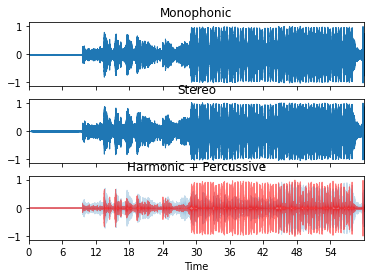

In [10]:
y, sr = librosa.load(output_filename, duration=60)
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
librosa.display.waveplot(y, sr=sr, ax=ax[0])
ax[0].set(title='Monophonic')
ax[0].label_outer()

y, sr = librosa.load(output_filename, mono=False, duration=60)
librosa.display.waveplot(y, sr=sr, ax=ax[1])
ax[1].set(title='Stereo')
ax[1].label_outer()

y, sr = librosa.load(output_filename, duration=60)
y_harm, y_perc = librosa.effects.hpss(y)
librosa.display.waveplot(y_harm, sr=sr, alpha=0.25, ax=ax[2])
librosa.display.waveplot(y_perc, sr=sr, color='r', alpha=0.5, ax=ax[2])
ax[2].set(title='Harmonic + Percussive')

# Add to audio features dataframe

In [13]:
audio_features_dict = {"song_id":song_id,
                       "youtube_link":yt_link,
                       "output_file": output_filename,
                       "title": title, 
                       "BPM": tempo, 
                       "key": key}

In [14]:
audio_features = pd.DataFrame(columns=audio_features_dict.keys())

In [15]:
audio_features = audio_features.append(audio_features_dict, ignore_index=True)
audio_features

,song_id,youtube_link,output_file,title,BPM,key
0,ogv284C4W30,https://www.youtube.com/watch?v=ogv284C4W30,"Kygo, Sasha Sloan - I'll Wait (Lyric Video)-og...","Kygo, Sasha Sloan - I'll Wait (Lyric Video)",123.046875,C# Maj


## Add new song to dateframe

In [19]:
def analyze_song(link, df):
    title, song_id, output_filename = download_song(link)
    tempo, beat_frames, beat_times = get_BPM(output_filename)
    key = computeKeyCl(output_filename)
    new_song_dict = {"song_id":song_id,
                       "youtube_link":link,
                       "output_file": output_filename,
                       "title": title, 
                       "BPM": tempo, 
                       "key": key}
    df = df.append(new_song_dict, ignore_index=True)
    df = df.drop_duplicates()
    return df

In [17]:
new_song_link = "https://www.youtube.com/watch?v=xarC5jAiO7w"
audio_features = analyze_song(new_song_link, audio_features)

[youtube] xarC5jAiO7w: Downloading webpage


ERROR: unable to download video data: HTTP Error 403: Forbidden


DownloadError: ERROR: unable to download video data: HTTP Error 403: Forbidden

In [20]:
audio_features.head()

,song_id,youtube_link,output_file,title,BPM,key
0,ogv284C4W30,https://www.youtube.com/watch?v=ogv284C4W30,"Kygo, Sasha Sloan - I'll Wait (Lyric Video)-og...","Kygo, Sasha Sloan - I'll Wait (Lyric Video)",123.046875,C# Maj


In [21]:
song_list = ["https://www.youtube.com/watch?v=SF8DGbfOFig", 
             "https://www.youtube.com/watch?v=Q77vdqA0hnM", 
             "https://www.youtube.com/watch?v=j2A1_OOTTss", 
             "https://www.youtube.com/watch?v=VIeY1J1M9Ts", 
             "https://www.youtube.com/watch?v=L-2CyO8pc0E", 
             "https://www.youtube.com/watch?v=q5rliCxX8xc", 
             "https://www.youtube.com/watch?v=A1eiTbiSrRc", 
             "https://www.youtube.com/watch?v=SKUk9RUacDQ", 
             "https://www.youtube.com/watch?v=nXOSgekiAJc"]

In [22]:
for song in song_list:
    audio_features = analyze_song(song, audio_features)
    
audio_features

[youtube] SF8DGbfOFig: Downloading webpage
[download] Destination: Total Science & S.P.Y - Piano Funk (Ft. Riya & DāM FunK) [320k]-SF8DGbfOFig.webm
[download] 100% of 5.57MiB in 00:0042MiB/s ETA 00:007
[ffmpeg] Destination: Total Science & S.P.Y - Piano Funk (Ft. Riya & DāM FunK) [320k]-SF8DGbfOFig.wav
Deleting original file Total Science & S.P.Y - Piano Funk (Ft. Riya & DāM FunK) [320k]-SF8DGbfOFig.webm (pass -k to keep)
[youtube] SF8DGbfOFig: Downloading webpage
Estimated tempo: 87.59 beats per minute
detected key:  G# Maj
[youtube] Q77vdqA0hnM: Downloading webpage
[download] Destination: Two Scoops-Q77vdqA0hnM.webm
[download] 100% of 1.96MiB in 00:0090MiB/s ETA 00:002
[ffmpeg] Destination: Two Scoops-Q77vdqA0hnM.wav
Deleting original file Two Scoops-Q77vdqA0hnM.webm (pass -k to keep)
[youtube] Q77vdqA0hnM: Downloading webpage
Estimated tempo: 172.27 beats per minute
detected key:  c min
[youtube] j2A1_OOTTss: Downloading webpage
[download] Destination: Oliver - Go With It (feat. 

,song_id,youtube_link,output_file,title,BPM,key
0,ogv284C4W30,https://www.youtube.com/watch?v=ogv284C4W30,"Kygo, Sasha Sloan - I'll Wait (Lyric Video)-og...","Kygo, Sasha Sloan - I'll Wait (Lyric Video)",123.046875,C# Maj
1,SF8DGbfOFig,https://www.youtube.com/watch?v=SF8DGbfOFig,Total Science & S.P.Y - Piano Funk (Ft. Riya &...,Total Science & S.P.Y - Piano Funk (Ft. Riya &...,87.592691,G# Maj
2,Q77vdqA0hnM,https://www.youtube.com/watch?v=Q77vdqA0hnM,Two Scoops-Q77vdqA0hnM.wav,Two Scoops,172.265625,c min
3,j2A1_OOTTss,https://www.youtube.com/watch?v=j2A1_OOTTss,Oliver - Go With It (feat. Chromeo)-j2A1_OOTTs...,Oliver - Go With It (feat. Chromeo),101.332721,C# Maj
4,VIeY1J1M9Ts,https://www.youtube.com/watch?v=VIeY1J1M9Ts,Vanilla - Go-VIeY1J1M9Ts.wav,Vanilla - Go,90.666118,d min
5,L-2CyO8pc0E,https://www.youtube.com/watch?v=L-2CyO8pc0E,Steve Monite - Only You-L-2CyO8pc0E.wav,Steve Monite - Only You,117.453835,e min
6,q5rliCxX8xc,https://www.youtube.com/watch?v=q5rliCxX8xc,Bicep - Glue (Original Mix)-q5rliCxX8xc.wav,Bicep - Glue (Original Mix),129.199219,e min
7,A1eiTbiSrRc,https://www.youtube.com/watch?v=A1eiTbiSrRc,OK - Cool - Aight feat. Conquer Jones-A1eiTbiS...,OK - Cool - Aight feat. Conquer Jones,126.048018,e min
8,SKUk9RUacDQ,https://www.youtube.com/watch?v=SKUk9RUacDQ,64 Ways (Dam Swindle's 65th Way Dub) feat. May...,64 Ways (Dam Swindle's 65th Way Dub) feat. May...,123.046875,G# Maj
9,nXOSgekiAJc,https://www.youtube.com/watch?v=nXOSgekiAJc,Disclosure - Expressing What Matters (Visualis...,Disclosure - Expressing What Matters (Visualiser),120.185320,b min


In [24]:
audio_features.head()

,song_id,youtube_link,output_file,title,BPM,key
0,ogv284C4W30,https://www.youtube.com/watch?v=ogv284C4W30,"Kygo, Sasha Sloan - I'll Wait (Lyric Video)-og...","Kygo, Sasha Sloan - I'll Wait (Lyric Video)",123.046875,C# Maj
1,SF8DGbfOFig,https://www.youtube.com/watch?v=SF8DGbfOFig,Total Science & S.P.Y - Piano Funk (Ft. Riya &...,Total Science & S.P.Y - Piano Funk (Ft. Riya &...,87.592691,G# Maj
2,Q77vdqA0hnM,https://www.youtube.com/watch?v=Q77vdqA0hnM,Two Scoops-Q77vdqA0hnM.wav,Two Scoops,172.265625,c min
3,j2A1_OOTTss,https://www.youtube.com/watch?v=j2A1_OOTTss,Oliver - Go With It (feat. Chromeo)-j2A1_OOTTs...,Oliver - Go With It (feat. Chromeo),101.332721,C# Maj
4,VIeY1J1M9Ts,https://www.youtube.com/watch?v=VIeY1J1M9Ts,Vanilla - Go-VIeY1J1M9Ts.wav,Vanilla - Go,90.666118,d min


# Split songs with Spleeter

In [25]:
# Using embedded configuration.
separator = Separator('spleeter:4stems')

def split_song(filename):
    separator.separate_to_file(filename, 'Downloads/')

In [26]:
for file in audio_features['output_file']:
    split_song(file)

INFO:tensorflow:Apply unet for vocals_spectrogram
INFO:tensorflow:Apply unet for drums_spectrogram
INFO:tensorflow:Apply unet for bass_spectrogram
INFO:tensorflow:Apply unet for other_spectrogram
INFO:tensorflow:Restoring parameters from pretrained_models/4stems/model


# Merge 2 wav files to new song

https://www.youtube.com/watch?v=0ALKGR0I5MA

In [33]:
song_1 = "64 Ways (Dam Swindle's 65th Way Dub) feat. Mayer Hawthorne-SKUk9RUacDQ.wav"
tempo_1, beat_frames_1, beat_times_1 = get_BPM(song_1)

Estimated tempo: 123.05 beats per minute


In [34]:
beat_frames_1

array([    9,    52,    94,   136,   178,   220,   262,   304,   346,
         388,   430,   472,   514,   556,   598,   640,   682,   724,
         766,   808,   850,   892,   934,   976,  1018,  1060,  1102,
        1144,  1186,  1228,  1270,  1312,  1354,  1396,  1438,  1480,
        1522,  1564,  1606,  1648,  1690,  1732,  1774,  1817,  1858,
        1900,  1942,  1984,  2026,  2069,  2111,  2152,  2194,  2236,
        2279,  2321,  2363,  2405,  2447,  2489,  2531,  2573,  2615,
        2657,  2699,  2741,  2783,  2825,  2867,  2909,  2951,  2993,
        3035,  3077,  3119,  3161,  3203,  3245,  3287,  3329,  3371,
        3413,  3455,  3497,  3539,  3581,  3623,  3665,  3707,  3749,
        3791,  3833,  3875,  3917,  3959,  4001,  4043,  4085,  4127,
        4169,  4211,  4253,  4295,  4338,  4379,  4422,  4463,  4505,
        4547,  4590,  4632,  4674,  4716,  4758,  4800,  4842,  4884,
        4926,  4968,  5010,  5052,  5094,  5136,  5178,  5220,  5262,
        5304,  5346,

In [35]:
song_2 = "Kygo, Sasha Sloan - I'll Wait (Lyric Video)-ogv284C4W30.wav"
tempo_2, beat_frames_2, beat_times_2 = get_BPM(song_2)

Estimated tempo: 123.05 beats per minute


In [36]:
beat_frames_2

array([ 1114,  1157,  1201,  1240,  1283,  1329,  1370,  1411,  1455,
        1500,  1536,  1578,  1619,  1661,  1706,  1744,  1781,  1826,
        1864,  1904,  1940,  1976,  2017,  2059,  2101,  2137,  2184,
        2228,  2270,  2312,  2353,  2395,  2437,  2479,  2526,  2574,
        2620,  2666,  2710,  2747,  2787,  2827,  2870,  2912,  2954,
        2995,  3036,  3074,  3119,  3164,  3203,  3242,  3281,  3320,
        3360,  3401,  3444,  3479,  3518,  3561,  3602,  3642,  3682,
        3722,  3762,  3802,  3844,  3887,  3929,  3971,  4011,  4055,
        4097,  4139,  4180,  4223,  4262,  4307,  4349,  4391,  4433,
        4475,  4516,  4559,  4601,  4643,  4684,  4727,  4769,  4811,
        4851,  4895,  4937,  4979,  5020,  5063,  5106,  5149,  5190,
        5233,  5275,  5317,  5358,  5401,  5442,  5480,  5518,  5566,
        5607,  5651,  5693,  5735,  5778,  5818,  5862,  5905,  5947,
        5988,  6030,  6074,  6115,  6157,  6193,  6237,  6282,  6324,
        6366,  6407,

In [46]:
sound1 = AudioSegment.from_file("Downloads/64 Ways (Dam Swindle's 65th Way Dub) feat. Mayer Hawthorne-SKUk9RUacDQ/drums.wav")
sound2 = AudioSegment.from_file("Downloads/Kygo, Sasha Sloan - I'll Wait (Lyric Video)-ogv284C4W30/other.wav")
combined = sound1.overlay(sound2)

combined.export("Mixed songs/64_kygo_combined2.wav", format='wav')

<_io.BufferedRandom name='Mixed songs/64_kygo_combined2.wav'>

In [47]:
import argparse
import matplotlib.pyplot as plt
import librosa
import numpy as np
import os
import soundfile as sf


def prepare(y, sr=22050):
    y = librosa.to_mono(y)
    y = librosa.util.fix_length(y, sr) # 1 second of audio
    y = librosa.util.normalize(y)
    return; y

def get_fingerprint(y, sr=22050):
    y = prepare(y, sr)
    cqt = librosa.cqt(y, sr=sr, hop_length=2048)
    return cqt.flatten('F')

def normalize(x):
    x -= x.min(axis=0)
    x /= x.max(axis=0)
    return x

def basename(file):
    file = os.path.basename(file)
    return os.path.splitext(file)[0]

vectors = []
words = []
filenames = []

y, sr = librosa.load("Kygo, Sasha Sloan - I'll Wait (Lyric Video)-ogv284C4W30.wav", sr=44100)
C = np.abs(librosa.cqt(y=y, sr=sr))
o_env = librosa.onset.onset_strength(sr=sr, S=librosa.amplitude_to_db(C, ref=np.max))
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

onset_samples = list(librosa.frames_to_samples(onset_frames))
onset_samples = np.concatenate(onset_samples, len(y))
starts = onset_samples[0:-1]
stops = onset_samples[1:]
analysis_folder = "Mixed songs/"
samples_folder = os.path.join("Mixed songs/", 'samples')
try:
	os.makedirs(samples_folder)
except:
	pass
enumeration = enumerate(zip(starts, stops))
#print(list(enumeration))
for i, (start, stop) in enumeration:
    audio = y[start:stop]
    filename = os.path.join(samples_folder, str(i) + '.wav')
    sf.write(filename, audio, sr)
    vector = get_fingerprint(audio, sr=sr)
    word = basename(filename)
    vectors.append(vector)
    words.append(word)
    filenames.append(filename)
np.savetxt(os.path.join(analysis_folder, 'vectors'), vectors, fmt='%.5f', delimiter='\t')
np.savetxt(os.path.join(analysis_folder, 'words'), words, fmt='%s')
np.savetxt(os.path.join(analysis_folder, 'filenames.txt'), filenames, fmt='%s')

KeyboardInterrupt: 